16

In [ ]:
pool.map(solve, [1,2,3,4,5,6,7,8,9,10])

In [ ]:
import pyblaze.multiprocessing as xmp

def parallel(texts):
    tokenizer = xmp.Vectorizer(tokenize, num_workers=4)
    return tokenizer.process(texts)

In [72]:
import pandas as pd
import os
from datetime import datetime, timedelta
import pickle
from dask import dataframe
#import dask
#from dask.distributed import Client
#client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='6GB')
#client

In [65]:
df = pd.read_csv(os.path.join('data','yellow_tripdata_2016-06.csv'), parse_dates=['tpep_dropoff_datetime','tpep_pickup_datetime'])

In [80]:
df['pickup_latitude'].value_counts()

0.000000     30520
40.774120      780
40.774109      739
40.774158      734
40.774139      699
             ...  
40.837753        1
40.851990        1
40.879028        1
40.635666        1
40.651424        1
Name: pickup_latitude, Length: 49063, dtype: int64

Num rows in df reduced from 11135470 to 2624066 


In [67]:
df['duration_minutes'] = (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).apply(lambda x: x.total_seconds()/60)
df = df.sort_values(['tpep_pickup_datetime'])
df['passenger_count'].fillna(2, inplace=True)
df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_minutes
3029890,1,2016-06-06 18:51:36,2016-06-06 19:09:14,1,2.90,-74.002792,40.760544,1,N,-74.003464,40.723938,1,14.5,1.0,0.5,3.25,0.0,0.3,19.55,17.633333
2178836,2,2016-06-10 12:37:19,2016-06-10 12:53:55,1,1.07,-73.965576,40.771500,1,N,-73.955780,40.784916,2,10.5,0.0,0.5,0.00,0.0,0.3,11.30,16.600000
3808832,1,2016-06-08 15:49:04,2016-06-08 15:54:34,1,1.30,-73.953918,40.778458,1,N,-73.942307,40.789738,1,6.5,1.0,0.5,1.70,0.0,0.3,10.00,5.500000


In [73]:
# angle df
angle_matrix = pd.read_csv('data/angle_matrix.csv', index_col='OBJECTID')
angle_matrix.columns = angle_matrix.columns.astype(int)
def apply_calculate_angle(row):
    try:
        return angle_matrix.loc[row['PULocationID'],row['DOLocationID']]
    except:
        return float("NaN")
# location df
location_df = pd.read_csv('data/location_df.csv', index_col='OBJECTID')
location_df.head(3)

,Shape_Leng,Shape_Area,zone,LocationID,borough,lon,lat
OBJECTID,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,9.359968e+05,191376.749531
2,0.433470,0.004866,Jamaica Bay,2,Queens,1.031086e+06,164018.754403
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.026453e+06,254265.478659


In [74]:
# Filter
#Drop 0 or neg length trips
#Drop 0 or neg length duration 
df = df[df['duration_minutes']>0]
df = df[df['trip_distance']>0]
#df['trip_distance_round'] = df['trip_distance'].round(2)

df['hour'] = df['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d-%H')
df['direction'] = df.apply(apply_calculate_angle,axis=1)

# Try Algorithm

In [44]:
from functools import partial
def angle_diff(a1, a2):
    d_a = a1-a2
    if d_a>180:
        d_a -= 360
    elif d_a<-180:
        d_a += 360
    return abs(d_a)

In [50]:
def algorithm_A(_df, max_wait_mins=7, max_occupancy=6):
    agg_rides = []
    if len(_df.shape) == 1:
        return 0
    try:
        df = _df.sort_values(by='tpep_pickup_datetime').copy()
        #n_matches = 0
        n_matches_list = []
        while df.shape[0]>1:
            agg_ride_dict = {f'ride_id_{i}':float("NaN") for i in range(max_occupancy)}
            i = df.index[0]
            agg_ride_dict['ride_id_0'] = i
            row = df.loc[i,:]
            initial_passengers = row['passenger_count']
            df.drop(index=i, inplace=True)
            t0 = row['tpep_pickup_datetime']
            delta_t = (df['tpep_pickup_datetime']-t0).dt.total_seconds()
            matches = df[delta_t<(60*max_wait_mins)]
            matches['cumulative_passengers'] = matches['passenger_count'].cumsum()
            matches = matches[matches['cumulative_passengers']<=(max_occupancy-initial_passengers)]
            #n_matches += matches.shape[0]
            for i, idx in enumerate(matches.index):
                agg_ride_dict[f'ride_id_{i+1}'] = idx
            #n_matches_list.append(matches.shape[0])
            df.drop(index=matches.index.values, inplace=True)
            agg_rides.append(agg_ride_dict)
    except Exception as e:
        print(_df)
        raise e
    return pd.DataFrame(agg_rides)#n_matches_list

def algorithm_B(_df, max_wait_mins=7, max_occupancy=6):
    # same pickup location
    agg_rides = []
    if len(_df.shape) == 1:
        return 0
    try:
        df = _df.sort_values(by='tpep_pickup_datetime').copy()
        #n_matches = 0
        n_matches_list = []
        while df.shape[0]>1:
            agg_ride_dict = {f'ride_id_{i}':float("NaN") for i in range(max_occupancy)}
            i = df.index[0]
            agg_ride_dict['ride_id_0'] = i
            row = df.loc[i,:]
            df.drop(index=i, inplace=True)
            # check capacity
            initial_passengers = row['passenger_count']
            if initial_passengers==max_occupancy:
                continue
            # Filter by pickup time
            t0 = row['tpep_pickup_datetime']
            delta_t = (df['tpep_pickup_datetime']-t0).dt.total_seconds()
            matches = df[delta_t<(60*max_wait_mins)]
            if matches.shape[0]==0:
                continue
            # Filter by angle
            angle_diff_from_a = partial(angle_diff, a2=row['direction'])
            angle_diffs = matches['direction'].apply(angle_diff_from_a)
            #print(angle_diffs)
            matches = matches[angle_diffs<45]
            if matches.shape[0]==0:
                continue
            # Combine until full
            matches['cumulative_passengers'] = matches['passenger_count'].cumsum()
            matches = matches[matches['cumulative_passengers']<=(max_occupancy-initial_passengers)]
            #n_matches += matches.shape[0]
            for i, idx in enumerate(matches.index):
                agg_ride_dict[f'ride_id_{i+1}'] = idx
            #n_matches_list.append(matches.shape[0])
            df.drop(index=matches.index.values, inplace=True)
            agg_rides.append(agg_ride_dict)
    except Exception as e:
        #print(_df)
        raise e
    return pd.DataFrame(agg_rides)#n_matches_list


In [75]:
df_sample = df.iloc[-100000:,:]
ddf_sample = dataframe.from_pandas(df_sample, npartitions=32)

In [77]:
df.

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_minutes,hour,direction
2128992,1,2016-06-06 00:00:00,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,20.0,0.5,0.5,0.00,0.0,0.3,21.30,16.950000,2016-06-06-00,NaN
2765158,2,2016-06-06 00:00:00,2016-06-06 18:07:49,1,2.02,-73.978745,40.750641,1,N,-73.997108,...,10.0,1.3,0.5,1.25,0.0,0.3,13.35,1087.816667,2016-06-06-00,NaN
2765159,2,2016-06-06 00:00:01,2016-06-06 00:04:05,2,1.37,-73.980690,40.742210,1,N,-73.967842,...,6.0,0.5,0.5,1.82,0.0,0.3,9.12,4.066667,2016-06-06-00,NaN
2128993,1,2016-06-06 00:00:02,2016-06-06 00:03:36,1,0.90,-73.986794,40.756310,1,N,-73.976067,...,5.0,0.5,0.5,0.00,0.0,0.3,6.30,3.566667,2016-06-06-00,NaN
2128995,2,2016-06-06 00:00:03,2016-06-06 00:00:35,1,0.02,-74.004211,40.742249,1,N,-74.001801,...,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.533333,2016-06-06-00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4563552,2,2016-06-12 23:57:11,2016-06-12 23:59:13,3,0.26,-73.962296,40.795040,1,N,-73.962173,...,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2.033333,2016-06-12-23,NaN
4563559,1,2016-06-12 23:57:15,2016-06-12 23:58:16,1,0.40,-73.986290,40.755920,1,N,-73.990410,...,3.5,0.5,0.5,0.00,0.0,0.3,4.80,1.016667,2016-06-12-23,NaN
4563699,2,2016-06-12 23:57:26,2016-06-12 23:59:35,1,0.41,-73.953918,40.771111,1,N,-73.956787,...,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2.150000,2016-06-12-23,NaN
4564019,1,2016-06-12 23:57:57,2016-06-12 23:59:12,1,0.20,-73.983192,40.759499,1,N,-73.980507,...,3.0,0.5,0.5,0.00,0.0,0.3,4.30,1.250000,2016-06-12-23,NaN


In [76]:
import time
t0 = time.time()
result_0 = ddf_sample.groupby(['PULocationID','DOLocationID']).apply(algorithm_A).compute()
print(f"complete in {time.time()-t0} seconds using dask")

t0 = time.time()
result_0 = df_sample.groupby(['PULocationID','DOLocationID']).apply(algorithm_A)
print(f"complete in {time.time()-t0} seconds using pandas")

KeyError: 'PULocationID'

In [52]:
import numpy as np
import time
t0 = time.time()
result_B = df_sample.groupby(['PULocationID']).apply(algorithm_B)
print(f"Algorithm B complete in {time.time()-t0} seconds without grouping")

Algorithm B complete in 14.153134107589722 seconds without grouping


In [53]:
result_B.head(3)

ride_id_0  ride_id_1  ride_id_2  ride_id_3  ride_id_4  \
PULocationID                                                            
13           0  1261220.0  1260528.0  1260823.0  1262371.0        NaN   
             1  1263004.0  1261191.0  1261073.0  1261074.0        NaN   
             2  1357209.0  1264454.0        NaN        NaN        NaN   

                ride_id_5  ride_id_6  ride_id_7  
PULocationID                                     
13           0        NaN        NaN        NaN  
             1        NaN        NaN        NaN  
             2        NaN        NaN        NaN

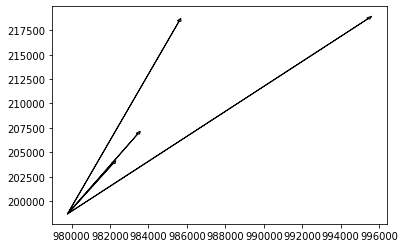

In [54]:
from matplotlib import pyplot as plt
def plot_rides(ride_ids):
    pu_locations = df.loc[ride_ids,'PULocationID']
    do_locations = df.loc[ride_ids,'DOLocationID']
    pu_lats = [location_df.loc[l,'lat'] for l in pu_locations]
    pu_lons = [location_df.loc[l,'lon'] for l in pu_locations]
    do_lats = [location_df.loc[l,'lat'] for l in do_locations]
    do_lons = [location_df.loc[l,'lon'] for l in do_locations]
    for pu_lat, pu_lon, do_lat, do_lon in zip(pu_lats, pu_lons, do_lats, do_lons):
        plt.arrow(pu_lon, pu_lat, dx=do_lon-pu_lon, dy=do_lat-pu_lat, width=10,head_width=200)
    plt.show()
plot_rides([1261220,1260528,1260823,1262371])  

complete in 277.2395770549774 seconds without grouping


In [94]:
t0 = time.time()
result_0 = df_sample.groupby(['PULocationID','DOLocationID','hour']).apply(algorithm)
print(f"complete in {time.time()-t0} seconds with grouping")

complete in 200.70719504356384 seconds with grouping


In [11]:
#dd = dask.dataframe.from_pandas(df_sample)
#t0 = time.time()
#result_2 = dd.groupby(['PULocationID','DOLocationID']).apply(algorithm)
#print(f"complete in {time.time()-t0} seconds via prallelization")

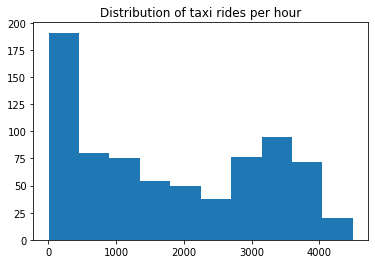

In [167]:
plt.title("Distribution of taxi rides per hour")
plt.hist(df['hour'].value_counts().values)
plt.show()

# Figure out load/unload delays

In [129]:
median_time = df[df['trip_distance_round']<20].groupby(['trip_distance_round'])['duration_minutes'].apply(np.median)

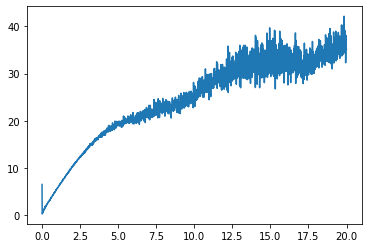

In [130]:
plt.plot(median_time)

In [128]:
median_time

trip_distance_round
0.00     6.483333
0.01     0.233333
0.02     0.300000
0.03     0.441667
0.04     0.500000
          ...    
1.95    10.091667
1.96    10.116667
1.97    10.083333
1.98    10.216667
1.99    10.183333
Name: duration_minutes, Length: 200, dtype: float64

C:\Util\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 120.0)

C:\Users\volpir\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


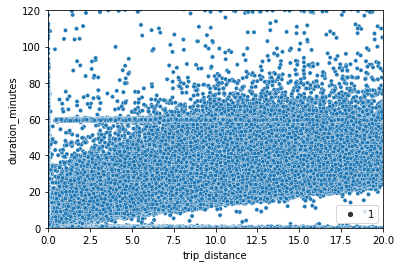

In [113]:
import seaborn as sns
sns.scatterplot(df['trip_distance'],df['duration_minutes'],size=1)
plt.xlim(0,20)
plt.ylim(0,120)

In [106]:
df['trip_distance']

0           2.10
1           0.20
2          14.70
3          10.60
4           4.94
           ...  
1369760     8.80
1369761     5.86
1369762     4.45
1369763    10.04
1369764     4.93
Name: trip_distance, Length: 1369765, dtype: float64

In [11]:
len(df['PULocationID'].unique())

258

#### 1. Propose a metric and/or algorithm to assess the potential efficiency of aggregating rides from many vehicles into one, given the available data. Make realistic assumptions and any necessary simplifications and state them.

The metric we want is the following: 

User-Miles Travelled / Vehicle Miles Traveled
User Effective Travel Time Completed / Vehicle Travel Time

We want to maximize this metric by minimizing the denominator, Vehicle Miles Traveled, while meeting all demand.

Iteratively apply the following heuristic 
    Start with longest trips first 
    Look for trips that overlap
    If consolidating a trip to a route doesn't add more than 20% to the total travel time of either trip, do it 
    
    
Assumptions
- trips are requested five minutes before pickup 
- trips start/end at the centroid of the shapefile for the region in which the trip starts/ends

In [19]:
import numpy as np
avg_travel_time = df.select_dtypes('number').groupby(['PULocationID','DOLocationID'])['duration_minutes'].apply(np.nanmean)
num_trips = df.select_dtypes('number').groupby(['PULocationID','DOLocationID'])['duration_minutes'].apply(lambda x: x.notna().sum())

In [32]:
avg_travel_time_matrix = pd.pivot_table(pd.DataFrame(avg_travel_time), index='PULocationID', columns='DOLocationID', values='duration_minutes')
num_trips_matrix = pd.pivot_table(pd.DataFrame(num_trips), index='PULocationID', columns='DOLocationID', values='duration_minutes')

In [38]:
# Fill missing trip distance with reverse distance
avg_travel_time_matrix[avg_travel_time_matrix.isna()] = avg_travel_time_matrix.T[avg_travel_time_matrix.isna()]

In [ ]:
from cipy.sparse.csgraph import shortest_path

shortest_path(csgraph, method='auto', directed=True)#, return_predecessors=False, unweighted=False, overwrite=False, indices=None)

In [81]:
def calculate_distance(a, b): #256, 261
    return avg_travel_time_matrix.loc[a,b]
#def calculate_distances(**tups):
#    dist = sum([calculate_distance(tup) for tup in tups])
def calculate_route(stops):
    dist = 0
    for i in range(len(stops)-1):
        #print(f"Dist from {stop[i]} to {stop[i+1]} = {calculate_distance(stop[i], stop[i+1])}")
        dist += calculate_distance(stops[i], stops[i+1])
    return dist

def shortest_path(pu_1, pu_2, do_1, do_2):
    route_options = [
        [pu_1, pu_2, do_1, do_2],
        [pu_1, pu_2, do_2, do_1],
        [pu_2, pu_1, do_1, do_2],
        [pu_2, pu_1, do_2, do_1],
    ]
    
    route_distances = [calculate_route(route) for route in route_options]
    
    ranked_distances, ranked_routes = zip(*sorted(zip(route_distances, route_options)))
    
    return ranked_distances[0], ranked_routes[0]

calculate_distance(256, 261)

NameError: name 'avg_travel_time_matrix' is not defined

In [54]:
def angle_dist(a, b):
    return ((a-b) + 180) % 360 - 180

In [61]:
angle

,OBJECTID,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
0,1,0.000000,-1.290653,-2.178322,-1.779702,0.081198,-0.703655,-1.915881,-1.996751,-1.769916,...,-2.242176,-1.732262,-1.686417,-1.319239,-1.557793,-2.270933,-1.822161,-1.710078,-2.022497,-2.043701
1,2,1.850940,0.000000,3.090300,2.337168,1.339774,1.480877,2.705036,2.732638,-2.902792,...,3.060765,2.385399,2.335235,1.888371,2.886468,3.083285,2.718981,2.158601,2.636825,2.628077
2,3,0.963270,-0.051293,0.000000,0.609478,0.694363,0.573153,0.488531,0.588329,-0.381170,...,2.680429,0.519888,0.506814,0.439031,0.034385,3.031570,0.354848,0.680196,0.703423,0.741602
3,4,1.361890,-0.804424,-2.532115,0.000000,0.756360,0.529518,-2.285310,-2.500166,-1.759664,...,-2.627369,-1.250019,-0.790060,0.010745,-1.208776,-2.644198,-1.935526,1.081289,-2.724256,-2.797482
4,5,-3.060394,-1.801819,-2.447230,-2.385233,0.000000,-2.061036,-2.365570,-2.411127,-2.147508,...,-2.490844,-2.326484,-2.307473,-2.131472,-2.063104,-2.503683,-2.298276,-2.433467,-2.450867,-2.466209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,259,0.870660,-0.058308,-0.110023,0.497395,0.637910,0.510853,0.358052,0.422316,-0.322904,...,0.311602,0.418642,0.411313,0.372033,0.011234,0.000000,0.259869,0.573662,0.529673,0.560809
259,260,1.319432,-0.422612,-2.786745,1.206067,0.843317,0.718946,2.607668,2.784755,-1.647950,...,-2.887740,0.990803,0.884410,0.541197,-0.607190,-2.881724,0.000000,1.162316,2.373483,2.363286
260,261,1.431515,-0.982991,-2.461397,-2.060304,0.708126,0.390585,-2.206610,-2.363938,-1.811906,...,-2.547365,-1.795544,-1.614000,-0.447907,-1.402577,-2.567931,-1.979277,0.000000,-2.493616,-2.546406
261,262,1.119096,-0.504767,-2.438170,0.417337,0.690726,0.497529,-0.955317,-1.717976,-1.368657,...,-2.583290,0.143653,0.154804,0.192895,-0.670673,-2.611919,-0.768110,0.647977,0.000000,2.262014


In [48]:
calculate_route([256, 261, 262, 263])

0

In [53]:
calculate_distance(256, 261) + calculate_distance(262, 263)

20.496898432174508

In [52]:
shortest_path(256, 261, 262, 263)

(39.47132586289212, [256, 261, 263, 262])

In [84]:
unique_locations = sorted(list(set(avg_travel_time_matrix.index)&set(avg_travel_time_matrix.columns)))
avg_travel_time_matrix = avg_travel_time_matrix.loc[unique_locations,unique_locations]

In [91]:
avg_travel_time_matrix =  avg_travel_time_matrix.fillna(0)

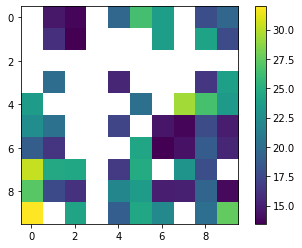

In [46]:
from matplotlib import pyplot as plt
plt.imshow(avg_travel_time_matrix.iloc[80:90,80:90])
plt.colorbar()

(0.0, 100.0)

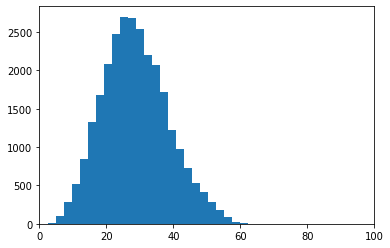

In [45]:
plt.hist(avg_travel_time_matrix.values.ravel(),bins=10000)
plt.xlim(0,100)

In [88]:
from sklearn.manifold import MDS
model = MDS(n_components=2, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='precomputed', metric=False)

In [133]:
symmetric_avg_travel_time_matrix = (avg_travel_time_matrix.T.values + avg_travel_time_matrix.values)/2

In [136]:
transformed = model.fit_transform(symmetric_avg_travel_time_matrix)

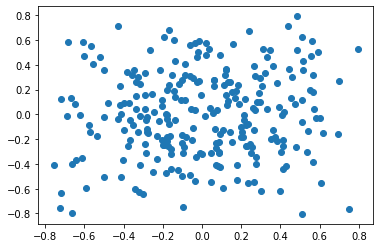

In [139]:
plt.scatter(transformed[:,0],transformed[:,1])

In [93]:
7*24*12

2016

In [ ]:
# Distance matrix
day-of-week (7)
hour-of-day (24)
month (12)

In [ ]:
# affinity = function that takes x and returns distance matrix 
# connectivity 